<a href="https://colab.research.google.com/github/HakanBayazitHabes/example_RNN_AI/blob/master/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN ile Hava Yolu Yolcu Sayısı Tahmini



1.   İş Problemeleri(Business Problem)
2.   Veriyi Anlamak(Data Understanding)
3.   Veriyi Hazırlamak(Data Preperation)
4.   Modelleme(Modelling)
5.   Değerlendirme(Evulation)



## 1- İş Problemleri(Business Problem)


*   **Month :** Aylık olarak yer alan arih değişkenidir.
*   **Passengers :** İlhili işlem tarihindeki yolcu sayısını, yani ylık yolcu sayısını temsil etmektedir.

**Dataset :** https://www.kaggle.com/andreazzini/international-airline-passengers


## 2- Veriyi Anlamak(Data Understanding)

2.1- Gerekli Kütüphaneleri İmport İşlemleri

In [91]:
# Veriyi okuma ve işleme adımında kullanılacak olan kütüphaneler
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

# Model değerlendirme ve veriyi scale edebilmemiz için kullanılacak olan kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Model için kullanılacak olan kütüphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Warningleri kapatmak için kullanılmaktadır.
import warnings
warnings.filterwarnings('ignore')

# Tensorflow Warning Engelleme
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## 2.2- Veri Setini Yüklenmesi ve Verinin Genel Resminin İncelenmesi

In [92]:
df = pd.read_csv("/content/sample_data/international-airline-passengers.csv")

In [93]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [94]:
df.columns

Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

In [95]:
df.columns = ["Month", "Passengers"]

In [96]:
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [97]:
# Sondaki gözlemleri gösterir
df.tail()

,Month,Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [98]:
df.shape

(145, 2)

In [99]:
df.dtypes

Month          object
Passengers    float64
dtype: object

In [100]:
df.isnull().sum()

Month         0
Passengers    1
dtype: int64

In [101]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


# 3- Veriyi Hazırlamak(Data Preparation)

In [102]:
df = df[:144]

In [103]:
df.tail()

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    object 
 1   Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [105]:
df["Month"]= pd.to_datetime(df["Month"])

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [107]:
print("Minimum Tarih:", df["Month"].min())
print("Maksimum Tarih:", df["Month"].max())

Minimum Tarih: 1949-01-01 00:00:00
Maksimum Tarih: 1960-12-01 00:00:00


In [108]:
df.index = df["Month"]

In [109]:
df.head()

,Month,Passengers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [110]:
df.drop("Month", axis=1, inplace=True)

In [111]:
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [112]:
result_df = df.copy()

<Axes: title={'center': 'Monthly airline passengers'}, xlabel='Month'>

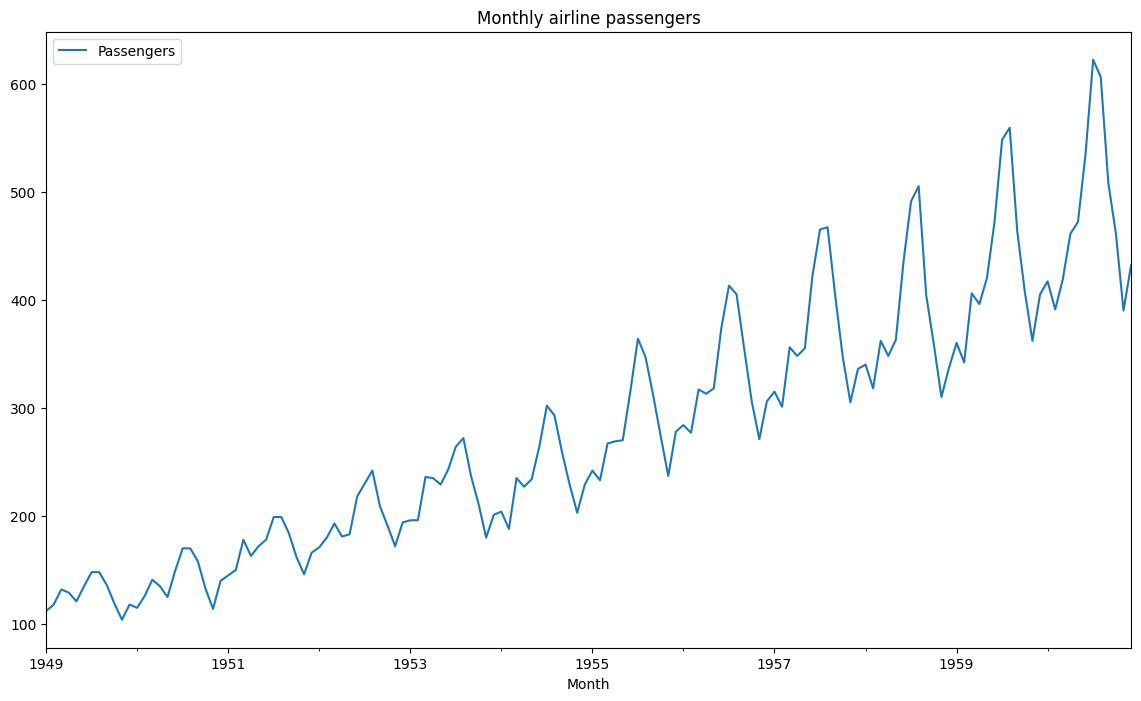

In [113]:
df.plot(figsize=(14, 8), title='Monthly airline passengers')

In [114]:
data = df["Passengers"].values

In [115]:
data[0:5]

array([112., 118., 132., 129., 121.])

In [116]:
type(data[0:5])

numpy.ndarray

In [117]:
type(data[0])

numpy.float64

In [118]:
data = data.astype('float32')

In [119]:
type(data[0])

numpy.float32

In [120]:
data.shape

(144,)

In [121]:
data = data.reshape(-1,1)

In [122]:
data.shape

(144, 1)

In [123]:
def split_data(dataframe, test_size):
  position = int(round(len(dataframe) * (1-test_size)))
  train = dataframe[:position]
  test = dataframe[position:]
  return train, test, position

In [124]:
train, test, position = split_data(data, 0.33)

In [125]:
print(train.shape, test.shape)

(96, 1) (48, 1)


In [126]:
scaler_train = MinMaxScaler(feature_range = (0,1))

In [127]:
train = scaler_train.fit_transform(train)

In [128]:
scaler_test = MinMaxScaler(feature_range = (0,1))

In [129]:
test = scaler_test.fit_transform(test)

In [130]:
train[0:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [131]:
test[0:5]

array([[0.04361373],
       [0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433]], dtype=float32)

In [132]:
def create_features(data, loookback):
  X, Y = [], []
  for i in range(lookback, len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])

  return np.array(X), np.array(Y)

In [133]:
lookback = 1

In [134]:
# Train Veri Seti
X_train, Y_train = create_features(train, lookback)

In [135]:
# Test Veri Seti
X_test, Y_test = create_features(test, lookback)

In [136]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(95, 1) (95,) (47, 1) (47,)


In [137]:
# Veri setini 3 boyutlu bir hale getirme işlemi bu işlemi yapma sebebimiz yapay siinir ağ verilerimizi 3 boyutlu istiyor.
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
Y_train = Y_train.reshape(-1,1)
Y_test = Y_test.reshape(-1,1)


In [138]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(95, 1, 1) (95, 1) (47, 1, 1) (47, 1)


# 4- Modelleme(Modleing)

In [139]:
model = Sequential()
model.add(SimpleRNN(units=50,
                    activation='relu',
                    input_shape=(X_train.shape[1], lookback)))

model.add(Dropout(0.2))
model.add(Dense(1))


In [140]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [141]:
# Optimizasyon ve Değerlendirme Metrikleri Ayarlanamsı

model.compile(loss='mean_squared_error', optimizer='adam')

In [142]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode="min"),
             ModelCheckpoint(filepath='mymodel.h5', monitor='val_loss',mode='min',
                             save_best_only=True, save_weights_only=False, verbose=1)]

In [143]:
history = model.fit(x=X_train,
                    y=Y_train,
                    epochs=50,
                    batch_size=1,
                    validation_data=(X_test, Y_test),
                    callbacks = callbacks,
                    shuffle=False)

Epoch 1/50
89/95 [===========================>..] - ETA: 0s - loss: 0.0120
Epoch 1: val_loss improved from inf to 0.04011, saving model to mymodel.h5
95/95 [==============================] - 2s 10ms/step - loss: 0.0159 - val_loss: 0.0401
Epoch 2/50
92/95 [============================>.] - ETA: 0s - loss: 0.0242
Epoch 2: val_loss improved from 0.04011 to 0.02444, saving model to mymodel.h5
95/95 [==============================] - 1s 6ms/step - loss: 0.0239 - val_loss: 0.0244
Epoch 3/50
92/95 [============================>.] - ETA: 0s - loss: 0.0167
Epoch 3: val_loss improved from 0.02444 to 0.02251, saving model to mymodel.h5
95/95 [==============================] - 1s 6ms/step - loss: 0.0162 - val_loss: 0.0225
Epoch 4/50
92/95 [============================>.] - ETA: 0s - loss: 0.0122
Epoch 4: val_loss improved from 0.02251 to 0.02097, saving model to mymodel.h5
95/95 [==============================] - 0s 5ms/step - loss: 0.0123 - val_loss: 0.0210
Epoch 5/50
82/95 [=====================

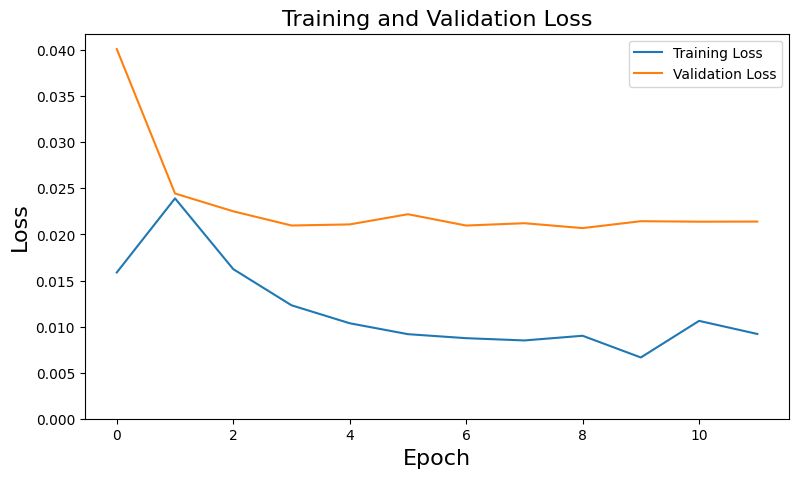

In [144]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

# 5- Değerlendirme(Evalution)

In [145]:
loss = model.evaluate(X_test, Y_test, batch_size=1)
print("\nTest loss: %.1f%%" % (100.0 * loss))

47/47 [==============================] - 0s 2ms/step - loss: 0.0214

Test loss: 2.1%


In [146]:
train_predict = model.predict(X_train)

3/3 [==============================] - 0s 5ms/step


In [147]:
test_predict = model.predict(X_test)

2/2 [==============================] - 0s 6ms/step


In [148]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [149]:
Y_train = scaler_train.inverse_transform(Y_train)
Y_test = scaler_test.inverse_transform(Y_test)

In [150]:
# Train veri setine ait RMSE değeri
train_rmse = np.sqrt(mean_squared_error(Y_train, train_predict))

In [151]:
# Test veri setine ait RMSE değeri
test_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))

In [152]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 23.565052032470703
Test RMSE: 46.95371627807617


çıkan Test RMSE değeri sapmayı bize verir. Örneğin diğer ay 300 yolcu gelecekse bunu 346(sapma 46 olarak kabul edersek) şeklinde tahmin etmiş oluyor.

In [153]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [154]:
# burdaki result_df ilk verilerimiz
train_prediction_df = result_df[lookback:position]

In [155]:
train_prediction_df["Predicted"] = train_predict

In [156]:
train_prediction_df.head()

,Passengers,Predicted
Month,,
1949-02-01,118.0,129.852097
1949-03-01,132.0,133.813782
1949-04-01,129.0,144.747040
1949-05-01,121.0,142.240723
1949-06-01,135.0,136.078094


In [158]:
test_prediction_df = result_df[position+lookback:]
test_prediction_df["Predicted"] = test_predict
test_prediction_df.head()

,Passengers,Predicted
Month,,
1957-02-01,301.0,331.561249
1957-03-01,356.0,324.009766
1957-04-01,348.0,367.591125
1957-05-01,355.0,360.069336
1957-06-01,422.0,366.650909


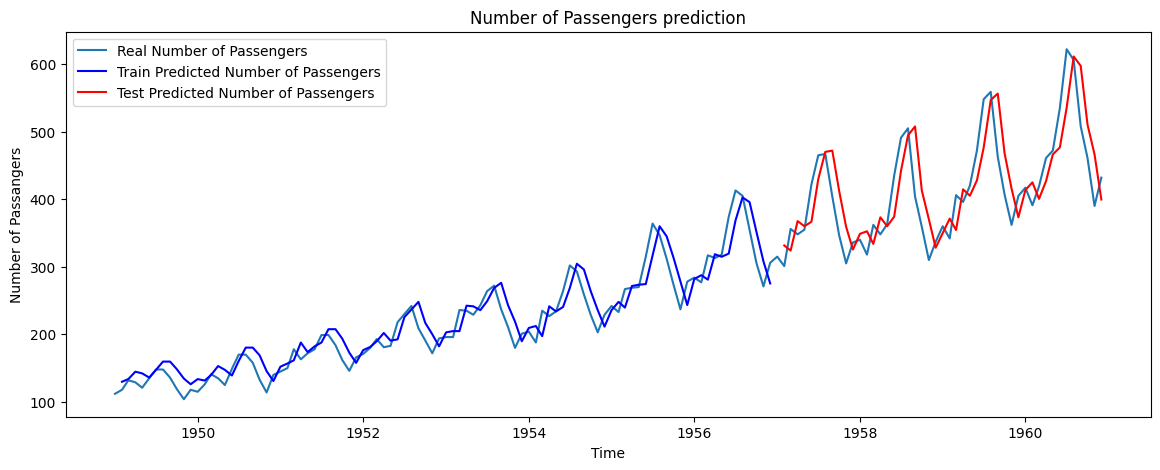

In [159]:
# Train ve Test Tahminlerini ayrı ayrı görselleştirme işlemi
plt.figure(figsize=(14,5))
plt.plot(result_df, label = 'Real Number of Passengers')
plt.plot(train_prediction_df["Predicted"], color='blue', label ='Train Predicted Number of Passengers')
plt.plot(test_prediction_df["Predicted"], color="red", label ='Test Predicted Number of Passengers')
plt.title('Number of Passengers prediction')
plt.xlabel('Time')
plt.ylabel('Number of Passangers')
plt.legend()
plt.show()